# Detección de Fraude: Modelos Avanzados (Coste Variable por Importe)

## Objetivo del Notebook

Este notebook implementa la estrategia de CSL más avanzada: **ponderación por muestra (`sample_weight`)**.

Como se vio en `varios_datasets.ipynb`, las estrategias simples (`class_weight='balanced'` y `SMOTE`) **fallan en datasets de desbalanceo extremo** (ej. "Credit Card Fraud"), resultando en un `F1-Score` (Fraude) muy bajo (ej. 0.119).

El objetivo aquí es demostrar que usando el **importe (`Amount`)** del fraude como un **coste variable** (`sample_weight`), podemos entrenar modelos (especialmente XGBoost y LightGBM) que **sí logran un F1-Score alto** en este escenario extremo.

**Metodología:**
1.  Se usará el dataset "Credit Card Fraud", que es ideal por su extremo desbalanceo (0.17% de fraude) y por incluir la columna `Amount`.
2.  Se crearán pesos (`sample_weight`) donde el coste de un error en un fraude es igual al `Amount` de esa transacción.
3.  Se compararán 5 modelos (Random Forest, Decision Tree, SVC, XGBoost y LightGBM) en dos escenarios: (1) **Convencional** y (2) **Avanzado (con `sample_weight`)**.
4.  La métrica de evaluación principal será la **Curva de Precisión-Recall (AUC-PR)**, ya que es la más indicada para datasets con desbalanceo extremo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

# Modelos a comparar
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Para mostrar gráficos
%matplotlib inline

## 1. Carga y Preparación de Datos (Credit Card Fraud)

Se carga el dataset "Credit Card Fraud" (ID 1597) desde OpenML.

El preprocesamiento es mínimo:
* Se guarda el `Amount` original en una variable separada para usarlo en los pesos.
* Se escala la columna `Amount` (`scaled_amount`) para usarla como *feature* en el modelo.
* Se elimina la columna `Amount` original del set de features `X`.

In [2]:
print("--- Cargando y Preparando el Dataset 'Credit Card Fraud' ---")

# Cargamos el dataset 'Credit Card Fraud'
data_fraud = fetch_openml(data_id=1597, as_frame=True, parser='auto')
X_fraud = data_fraud.data
y_fraud = pd.Series(pd.factorize(data_fraud.target)[0], index=data_fraud.target.index)
print("Dataset cargado.")

# Guardamos el importe original para usarlo en los pesos
amount_original = X_fraud['Amount'].copy()

# Preprocesamiento: Escalar únicamente la columna 'Amount'
scaler = StandardScaler()
X_fraud['scaled_amount'] = scaler.fit_transform(X_fraud[['Amount']])
X_fraud_proc = X_fraud.drop('Amount', axis=1)

print("Datos preprocesados.")

--- Cargando y Preparando el Dataset 'Credit Card Fraud' ---
Dataset cargado.
Datos preprocesados.


## 2. División de Datos y Creación de Pesos

Primero, se dividen los datos en conjuntos de entrenamiento (70%) y prueba (30%), asegurando la estratificación (`stratify=y`) para mantener la proporción de fraude en ambos.

In [3]:
# División de datos (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_fraud_proc, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

print(f"Datos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

Datos divididos: 199364 para entrenar, 85443 para probar.


A continuación, se implementa la lógica del **coste variable**. Se crea un array `sample_weights` basado únicamente en los datos de entrenamiento (`X_train`):

* Si una transacción es **normal (clase 0)**, su peso es **1**.
* Si una transacción es un **fraude (clase 1)**, su peso es **Importe + 1** (se suma 1 para evitar pesos de 0 en fraudes de 0€).

Este array se pasará al método `.fit()` de los modelos avanzados: `model.fit(X_train, y_train, sample_weight=sample_weights)`.

In [4]:
# Creación de los pesos basados en el importe
amount_train = amount_original.loc[y_train.index]

# Usamos np.where: si y_train es 1, usamos amount_train + 1, si no, usamos 1
sample_weights = pd.Series(
    np.where(y_train == 1, amount_train + 1, 1),
    index=y_train.index
)

print("Pesos por muestra (sample_weight) creados correctamente.")

Pesos por muestra (sample_weight) creados correctamente.


## 3. Definición y Benchmark de Modelos

Se define el diccionario de modelos a comparar. Se incluyen los modelos de `varios_datasets.ipynb` (RF, DT, SVC) y se añaden modelos de *boosting* (XGBoost, LightGBM), que son muy potentes en detección de fraude.

**Nota:** Se incluye `probability=True` en SVC para poder calcular las probabilidades (`predict_proba()`) necesarias para la curva P-R.

In [5]:
# Diccionario de los modelos que vamos a probar
# (probability=True es para poder calcular la curva P-R)
models_to_benchmark = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(random_state=42, probability=True),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Diccionario para guardar todos los resultados para la gráfica final
plot_results = {}

Se inicia el benchmark. Para cada uno de los 5 modelos, se entrenan y evalúan dos versiones:

1.  **Modelo Convencional:** Entrenado solo con `X_train, y_train`.
2.  **Modelo Avanzado (CSL):** Entrenado con `X_train, y_train` y `sample_weight=sample_weights`.

Se imprimen los reportes de clasificación de ambas versiones para una comparación directa del rendimiento con el umbral por defecto (0.5). Los datos de la curva P-R (probabilidades) se guardan para la gráfica final.

In [6]:
print("INICIANDO BENCHMARK DE MODELOS DE VANGUARDIA")

for model_name, model_base in models_to_benchmark.items():
    
    print(f"\n{'='*60}\nProbando modelo: {model_name}\n{'='*60}")
    
    # --- 1. Modelo Convencional ---
    print(f"Entrenando {model_name} (Convencional)...")
    model_conv = model_base.set_params(random_state=42)
    model_conv.fit(X_train, y_train)
    y_pred_conv = model_conv.predict(X_test)
    y_probs_conv = model_conv.predict_proba(X_test)[:, 1]
    
    print("\n--- Resultados (Convencional) ---")
    print(confusion_matrix(y_test, y_pred_conv))
    print(classification_report(y_test, y_pred_conv, target_names=['Normal', 'Fraude'], zero_division=0))

    # --- 2. Modelo Avanzado (sample_weight) ---
    print(f"Entrenando {model_name} (Avanzado con sample_weight)...")
    model_adv = model_base.set_params(random_state=42)
    model_adv.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred_adv = model_adv.predict(X_test)
    y_probs_adv = model_adv.predict_proba(X_test)[:, 1]
    
    print("\n--- Resultados (Avanzado Sensible al Importe) ---")
    print(confusion_matrix(y_test, y_pred_adv))
    print(classification_report(y_test, y_pred_adv, target_names=['Normal', 'Fraude'], zero_division=0))

    # --- 3. Guardar resultados para la gráfica ---
    precision_conv, recall_conv, _ = precision_recall_curve(y_test, y_probs_conv)
    precision_adv, recall_adv, _ = precision_recall_curve(y_test, y_probs_adv)
    
    plot_results[model_name] = {
        'conv': (recall_conv, precision_conv, auc(recall_conv, precision_conv)),
        'adv': (recall_adv, precision_adv, auc(recall_adv, precision_adv))
    }

print("\n--- Benchmark completado ---")

INICIANDO BENCHMARK DE MODELOS DE VANGUARDIA

Probando modelo: Random Forest
Entrenando Random Forest (Convencional)...

--- Resultados (Convencional) ---
[[85290     5]
 [   35   113]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.96      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Entrenando Random Forest (Avanzado con sample_weight)...

--- Resultados (Avanzado Sensible al Importe) ---
[[85291     4]
 [   41   107]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.96      0.72      0.83       148

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443


Probando modelo: Dec

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados (Convencional) ---
[[85287     8]
 [   40   108]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.93      0.73      0.82       148

    accuracy                           1.00     85443
   macro avg       0.97      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Entrenando XGBoost (Avanzado con sample_weight)...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados (Avanzado Sensible al Importe) ---
[[85287     8]
 [   32   116]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443


Probando modelo: LightGBM
Entrenando LightGBM (Convencional)...
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Star

## 4. Análisis de Resultados: F1-Score y Curva P-R

La métrica principal para evaluar el éxito es el **`F1-Score` de la clase Fraude** (visible en los reportes de clasificación de la celda 7) y el **AUC-PR** (visible en la gráfica de la celda 8).

La siguiente gráfica compara el rendimiento de los 5 modelos en sus dos versiones:

* **Línea Continua:** Rendimiento del modelo Convencional.
* **Línea Discontinua:** Rendimiento del modelo Avanzado (Coste Variable por Importe).

--- GENERANDO GRÁFICA COMPARATIVA P-R FINAL ---


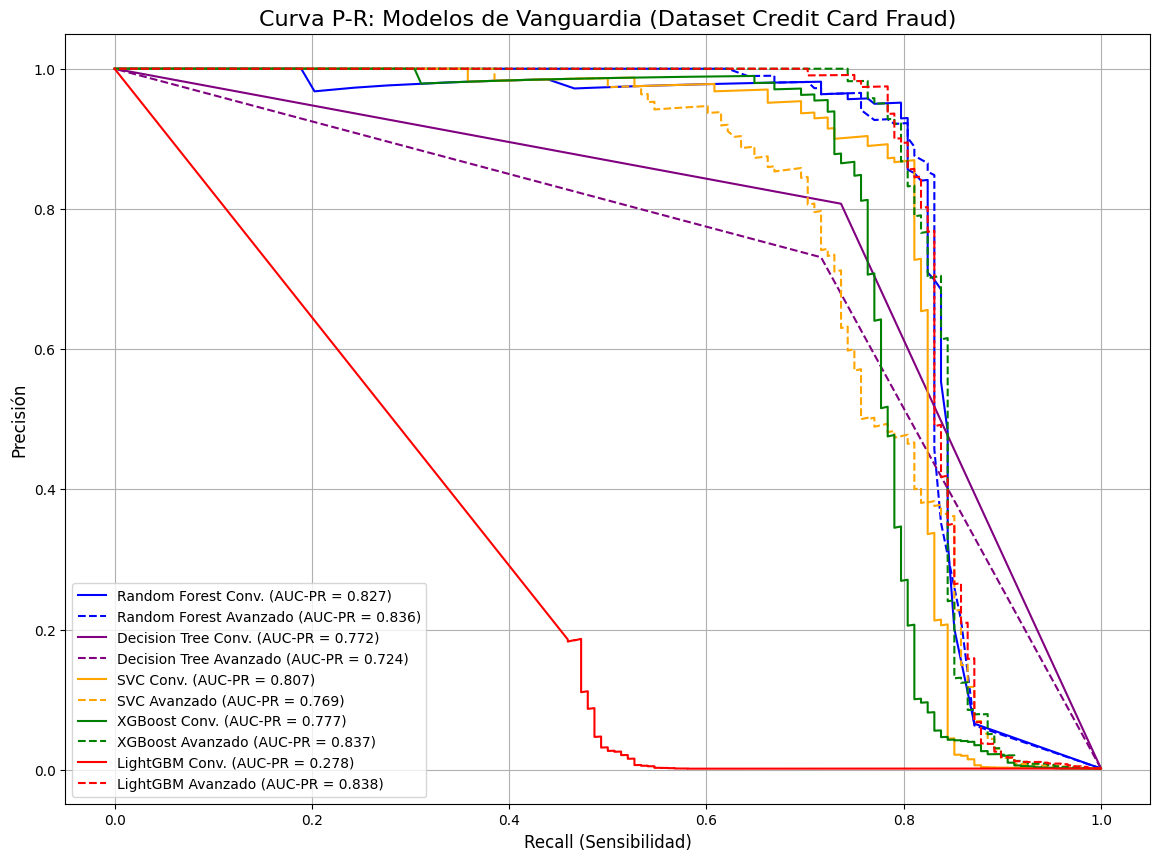

In [7]:
print("--- GENERANDO GRÁFICA COMPARATIVA P-R FINAL ---")

plt.figure(figsize=(14, 10))

# Definir colores para los modelos
colors = {
    'Random Forest': 'blue', 
    'XGBoost': 'green', 
    'LightGBM': 'red',
    'Decision Tree': 'purple',
    'SVC': 'orange'             
}

for model_name, results in plot_results.items():
    # Modelo Convencional (línea continua)
    recall_conv, precision_conv, auc_pr_conv = results['conv']
    plt.plot(recall_conv, precision_conv, 
             label=f'{model_name} Conv. (AUC-PR = {auc_pr_conv:.3f})', 
             color=colors[model_name], linestyle='-')
    
    # Modelo Avanzado (línea discontinua)
    recall_adv, precision_adv, auc_pr_adv = results['adv']
    plt.plot(recall_adv, precision_adv, 
             label=f'{model_name} Avanzado (AUC-PR = {auc_pr_adv:.3f})', 
             color=colors[model_name], linestyle='--')

plt.title('Curva P-R: Modelos de Vanguardia (Dataset Credit Card Fraud)', fontsize=16)
plt.xlabel('Recall (Sensibilidad)', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## 5. Conclusiones del Análisis de Coste Variable

Los resultados de la gráfica P-R son concluyentes y revelan patrones muy claros:

1.  **Efectividad del Coste Variable:** Los modelos de *boosting* (**LightGBM** y **XGBoost**) muestran una mejora drástica en el AUC-PR al utilizar `sample_weight`. El LightGBM, en particular, pasa de un AUC-PR de 0.278 (inútil) a **0.838**, demostrando que el coste sensible transforma el modelo. XGBoost también mejora notablemente (0.777 a 0.837).

2.  **Interacción con Modelos de Bagging:** El **Random Forest** (un modelo de *bagging*) muestra una mejora muy leve (0.827 vs 0.836). Esto es consistente con los hallazgos del notebook `varios_datasets.ipynb` (donde tampoco respondía bien a `class_weight`).

**Conclusión Final:** La estrategia de coste variable (`sample_weight`) basada en el importe es la más potente para modelos de *boosting* (LGBM, XGBoost). Para modelos de *bagging* (RF).